In [1]:
import numpy as np
from scipy.stats import truncnorm
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm


Bad key "text.kerning_factor" on line 4 in
C:\Users\GuilhermeYambanisTho\.conda\envs\cmdp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [125]:
# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman',
               pop_size = 1000, seed = None):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 5, 0.4, seed)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size, seed=seed)
    elif graph_model == 'SP':
        G = nx.read_gpickle('Grafo_Zonas_SP.gpickle')
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model, pop_size = 1000, seed=None):
    G = init_graph(initial_infection, graph_model, pop_size, seed)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """   
    for node in G.nodes():
        G.nodes[node].update({
                      'status': 'susceptible', 
                      'infection_day' : -1, 
                      'contacts_infected' : 0
        })

    size = int(len(G.nodes) * pct) 
    print(size)
    infected = np.random.choice(G.nodes, size = size, replace = False)
    
    for i in infected:
        susceptible_to_exposed(G.nodes[i], 0)


def spread_one_step(G, day, p_r = 0.5, lambda_leak = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
       
    for node, adjacencies in G.adjacency():
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies.keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    newly_infected = np.unique(newly_infected)
    
    infect_graph(G, newly_infected, day)
    
    return newly_infected.size


def simulate_one_step(G, day, recover_time=12, p_r=0.5, infectious_window=[4,6]):
    """
    Recover and Spread one step
    """
    recover_one_step(G, day, recover_time)
    newly_infected =  spread_one_step(G, day, p_r, infectious_window)
    return newly_infected

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and removed
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

def current_status_by_zone(G):
    nodes = np.array(G.nodes(data=True))[:,1]
    
    result = collections.Counter(node['home'] for i,node in G.nodes(data=True) \
                                            if node['status']=='infected')
    people_per_zone = dict(collections.Counter(node['home'] for i,node in G.nodes(data=True)))
    
    for k,v in result.items():
        result[k] = v/people_per_zone[k]
        
    return dict(result)


def get_mean_contacts_infected(G):
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True)\
                                                             if node['status'] == 'removed']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
            
        return contacts_infected
    
def get_time_series_row(G, pop):
    status = current_status(G)
    s = status['susceptible'] / pop
    i = status['infected'] / pop
    r = status['removed'] / pop
    h = status['hospitalized'] / pop
    e = status['exposed'] / pop

    contacts_infected = get_mean_contacts_infected(G)
    
    return s, e, i, r, h, contacts_infected, status
    
def simulate_pandemic(initial_infection=.05, recover_time=12, p_r=.5, lambda_leak=.05,
                      graph_model = 'relaxed_caveman', pop_size = 1000,
                      seed = None):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, pop_size, seed)
    
    data_per_region = []

    for day in tqdm(range(250)):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
    
        update_graph(G)
        
        newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        s, e, i, r, h, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, e, i, r, h, contacts_infected, status])
        
        data_per_region.append(current_status_by_zone(G))
        
    columns = ['susceptible', 'exposed', 'infected', 'removed', 'hospitalized', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series, G, data_per_region


In [126]:
def sample_truncated_norm(clip_low, clip_high, mean, std):
    a, b = (clip_low - mean) / std, (clip_high - mean) / std
    return int(truncnorm.rvs(a, b, mean, std))

def sample_incubation(clip_low = 2, clip_high = 15, mean = 6, std = 3):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_onset_to_hosp_or_asymp(clip_low = 2, clip_high = 21, mean = 6.2, std = 4.3):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_hospitalization_to_removed(clip_low = 2, clip_high = 32, mean = 8.6, std = 6.7):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def needs_hospitalization(chance_of_hosp = 0.05):
    return np.random.random() < chance_of_hosp

def susceptible_to_exposed(node, day):
    if node['status'] != 'susceptible':
        print(node)
        raise ValueError("Node status different from susceptible")
    
    node['status'] = 'exposed'
    node['period_duration'] = sample_incubation()
    node['infection_day'] = day
    
    return

def exposed_to_infected(node):
    if node['status'] != 'exposed':
        raise ValueError("Node status different from exposed")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
    
    node['status'] = 'infected'
    node['period_duration'] = sample_onset_to_hosp_or_asymp()
    
    return
    
def infected_to_new_state(node):
    if node['status'] != 'infected':
        raise ValueError("Node status different from infected")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
    
    if needs_hospitalization():
        node['status'] = 'hospitalized'
        node['period_duration'] = sample_hospitalization_to_removed()
    else:
        node['status'] = 'removed'
        
    return
        
def hospitalized_to_removed(node):
    if node['status'] != 'hospitalized':
        raise ValueError("Node status different from hospitalized")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
        
    node['status'] = 'removed'
    
    return

def change_state(node):
    if node['status'] == 'exposed':
        exposed_to_infected(node)
        return
    if node['status'] == 'infected':
        infected_to_new_state(node)
        return 
    if node['status'] == 'hospitalized':
        hospitalized_to_removed(node)
        return 

def update_node(node):
    if node['status'] == 'susceptible' or node['status'] == 'removed':
        return
    if node['period_duration'] == 0: 
        change_state(node)
        return 
    
    node['period_duration'] = node['period_duration'] - 1
    return

def infect_node(node, day):
    susceptible_to_exposed(node, day)
    return

def infect_graph(Graph, node_list, day):
    for n in node_list:
        infect_node(Graph.nodes[n], day)

def update_graph(Graph):
    for i, node in Graph.nodes(data=True):
        update_node(node)
        

1109


 37%|██████████████████████████████▏                                                  | 93/250 [01:28<02:28,  1.05it/s]


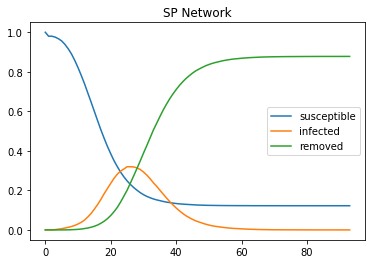

In [127]:
time_series, G, data_per_region = simulate_pandemic(graph_model = 'SP', p_r = 0.3,
                                                    lambda_leak=0, pop_size=5000, 
                                                    initial_infection = 100/5000)

plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['removed'], label = 'removed')
plt.legend()
plt.title('SP Network')
plt.savefig('SP network Simulation.png', fromat='png', dpi = 300)
plt.show()

In [128]:
ts_reg = pd.DataFrame(data_per_region)
ts_reg = ts_reg.reindex(sorted(ts_reg.columns), axis=1)
missing_cols = list(set(range(1, int(max(ts_reg.columns)))) - set(ts_reg.columns))

ts_reg = pd.concat([ts_reg, pd.DataFrame(columns=missing_cols)]).fillna(0).T

,index,day 0,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,...,day 86,day 87,day 88,day 89,day 90,day 91,day 92,day 93,day 94,day 95
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338,339.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
339,340.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340,341.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
ts_reg.columns = ts_reg.columns.to_series().apply(lambda x: f'day {int(x)}').values

In [130]:
import geopandas as gpd
gdf = gpd.read_file('..\\data\\raw\\OD 2017\\Mapas\\Shape\\Zonas_2017_region.shp')
gdf = gdf[gdf['NomeMunici'] == 'São Paulo']


In [113]:
ts_reg['day 24']

1.0      40.0
2.0      50.0
3.0      38.0
4.0      34.0
5.0      33.0
         ... 
338.0    39.0
339.0     0.0
340.0    64.0
341.0    26.0
342.0    42.0
Name: day 24, Length: 342, dtype: float64

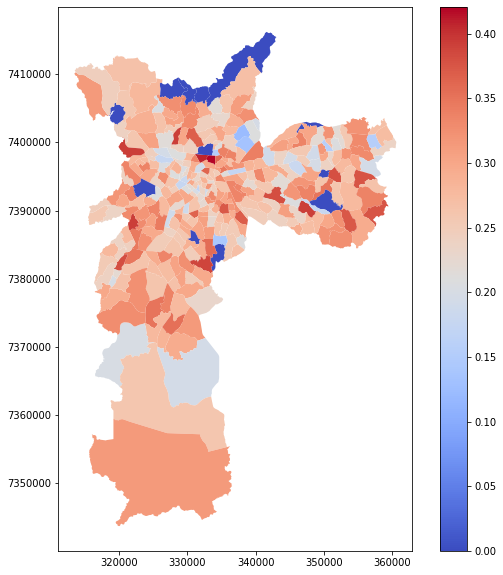

In [141]:
time_series_gdf = pd.concat([gdf, ts_reg.reset_index()], axis=1)
time_series_gdf.plot(column='day 30', cmap='coolwarm', legend=True,figsize=(10, 10));